### General rules:
 * For all figures that you generate, remember to add meaningful labels to the axes, and make a legend, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.
 * Replace *Template* by your *FirstnameLastname* in the filename, or by *Lastname1Lastname2* if you work in pairs.

# BCI-IL WS 2018/2019 - Exercise Sheet #06

#### Name:

In [1]:
import numpy as np
import scipy as sp
import scipy.signal
from matplotlib import pyplot as plt

import bci_minitoolbox as bci

## Load the data set

In [2]:
fname= 'eyes_closed_VPal.npz'
cnt, fs, clab, mnt = bci.load_data(fname)
C= np.cov(cnt)
d, V = np.linalg.eigh(C)
W_arti=V[:,[-1,-2]]
# -> Two components explain most of the variance.
# The std of those is above of what we would expect for brain sources.

## Exercise 1: Artifact Correction with PCA  (4 points)
Using the backward model, estimate the source activity corresponding to the two components that were found in Ex. \#01 of the last sheet (\#05) and plot the two obtained time series. Using the forward model, estimate that part of the measured EEG signals, that originates from these two sources. Subtract this multivariate signal from the original EEG. Compare the thus obtained cleaned signal in channel Fz with the original data.

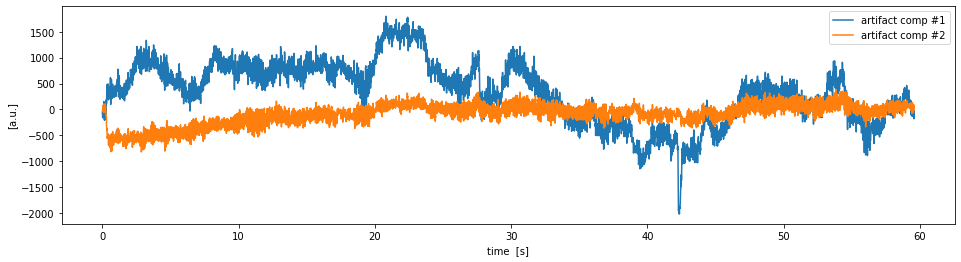

In [3]:
fz = clab.index('Fz')
S_arti = W_arti.T.dot(cnt)
time = np.arange(0, np.shape(cnt)[1]/fs, 1/fs)

plt.figure(figsize=(16,4))
plt.plot(time, S_arti.T)
plt.xlabel('time  [s]')
plt.ylabel('[a.u.]')
plt.legend(['artifact comp #1', 'artifact comp #2']);

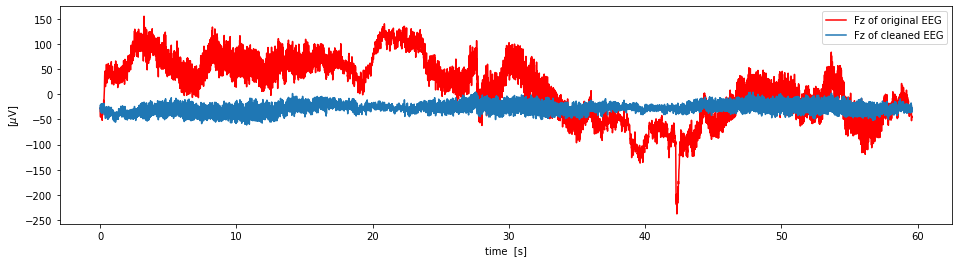

In [4]:
A_arti = W_arti
X_arti = A_arti.dot(S_arti)
X_clean = cnt - X_arti

plt.figure(figsize=(16,4))
plt.plot(time, cnt[fz], 'r', label='Fz of original EEG')
plt.plot(time, X_clean[fz], label='Fz of cleaned EEG')
plt.xlabel('time  [s]')
plt.ylabel('[$\mu$V]')
plt.legend();

## Exercise 2: PCA on band-pass filtered data (4 points)
Design a butterworth band-pass filter of order 10 with the frequency band 8-12 Hz (function `sp.signal.butter`). Apply that band-pass filter to the original EEG signals (function `sp.signal.lfilter`) and compare raw and filtered signals for channel Oz.
Visualize the covariance matrix (functions np.cov and pl.imshow) of the filtered data and check the eigenvalue spectrum, to determine how many strong principal components there are. Visualize those principal components ins the same way as in Ex. \#01 sheet \#05. Compare the results and discuss shortly.

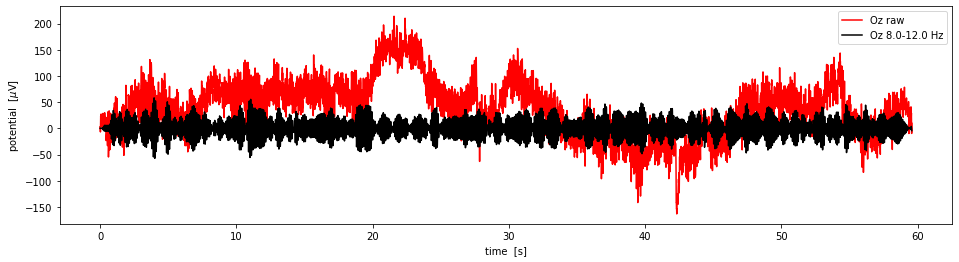

In [5]:
band = [8., 12.]
oz = clab.index('Oz')
Wn = np.array(band) / fs * 2
# for band-pass filters, you need to specify half! the order
b, a = sp.signal.butter(5, Wn, btype='bandpass')
Xf= sp.signal.lfilter(b, a, cnt)

plt.figure(figsize=(16,4))
plt.plot(time, cnt[oz], 'r', label='Oz raw')
plt.plot(time, Xf[oz], 'k', label='Oz {b[0]}-{b[1]} Hz'.format(b=band))
plt.xlabel('time  [s]')
plt.ylabel('potential  [$\mu$V]')
plt.legend();

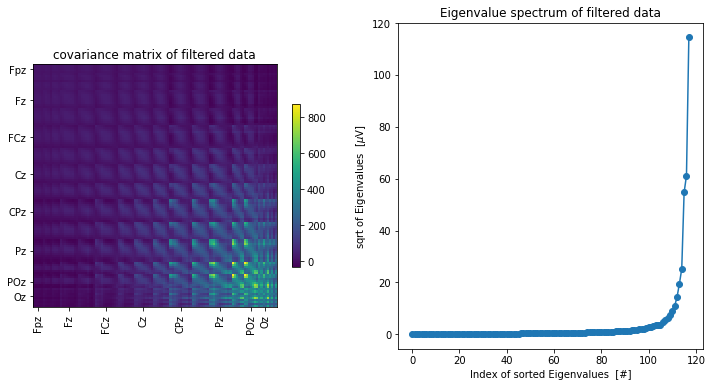

In [6]:
selected_channels = ['Fpz', 'Fz', 'FCz', 'Cz', 'CPz', 'Pz', 'POz', 'Oz']
idx = [clab.index(x) for x in selected_channels]
Cf= np.cov(Xf)
df, Vf= np.linalg.eigh(Cf)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(Cf)
plt.title('covariance matrix of filtered data')
plt.colorbar(shrink=.5)
plt.xticks(idx, selected_channels, rotation='vertical')
plt.yticks(idx, selected_channels)

plt.subplot(1, 2, 2)
plt.plot(np.sqrt(df), '-o' )
plt.title('Eigenvalue spectrum of filtered data')
plt.xlabel('Index of sorted Eigenvalues  [#]')
plt.ylabel('sqrt of Eigenvalues  [$\mu$V]');

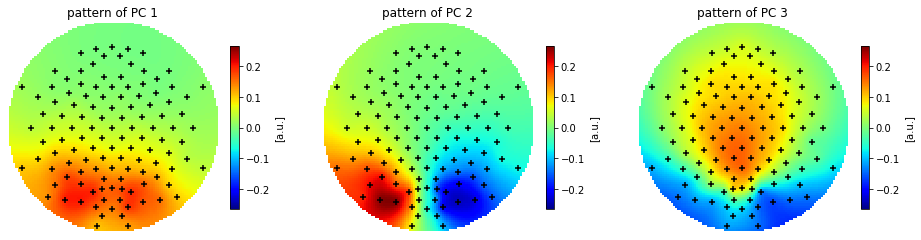

In [7]:
nPCs = 3
lims=np.max(abs( Vf[:,-nPCs:-1]))

plt.figure(figsize=(16, 6))
for k in range(nPCs):
  plt.subplot(1, 3, k+1)
  bci.scalpmap(mnt, Vf[:, -(k+1)], clim=[-lims ,lims], cb_label='[a.u.]')
  plt.title("pattern of PC {}".format(k+1))

The scalp patterns in Ex \#01 were dominated from eye movement artifacts. These are in the low frequencies. The main contribution in the 8-12 Hz (*alpha*) band comes from the visual cortex. Accordingly, we find here:
* PC1: monopolar pattern in the occipital area (visual cortex)
* PC2: bipolar pattern in the occipital area
* PC3: bipolar pattern with focus in centro-parietal area and other in occipital

## Exercise 3: Reconstruction with few PCs  (3 points)
Calculate the signals corresponding to the strongest principal components (second part of Ex. \#02) of the filtered data (project EEG data onto the PCs, i.e. go from *sensor space* to *source space*). Then reconstruct the EEG data from those strong principal components, i.e. project the signals obtained in the first step back into *sensor space*. Compare the band-pass filtered signal with the reconstructed signal in channel Oz. For plotting, the first six seconds are enough. You can also apply an error measure of your choice.

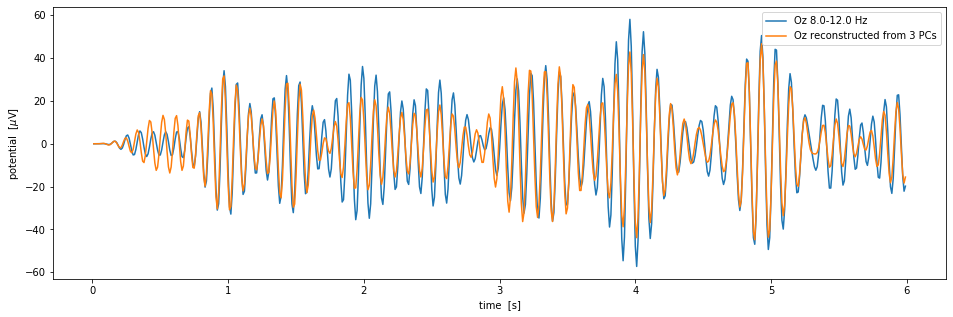

In [8]:
V0 = V[:, -nPCs:]
P = V0.dot(V0.T)
Xf2 = P.dot(Xf)

plt.figure(figsize=(16,5))
timeidx= np.arange(1, 6*fs)
plt.plot(time[timeidx], Xf[oz, timeidx], label='Oz {b[0]}-{b[1]} Hz'.format(b=band))
plt.plot(time[timeidx], Xf2[oz, timeidx], label='Oz reconstructed from {} PCs'.format(nPCs))
plt.xlabel('time  [s]')
plt.ylabel('potential  [$\mu$V]')
plt.legend()

## Exercise 4: Artifact to signal ratio in bandpass-filtered signal  (4 points)
For this task we again assume that the two components from Ex. \#01 sheet \#05 reflect eye movements, while all other components do not contain artifacts from eye movement.

Determine for each channel which proportion of the overall variance caused by these eye movements is left after bandpass-filtering and plot this information as a scalp map. Also, calculate the Signal-To-Noise ratio (SNR) per channel in Decibel (dB).

*Hint: The PCA for these components was done on the unfiltered signal, while the filtered signal has a different covariance matrix.*

### Remarks to the solution
This solution is methodologically problematic, because PCA components are not independent in general, only uncorrelated in the sampled data. It reveals that unmixing doesn't seem to work properly. So we can learn a lot from it. We would need a different approach to estimate the amount of eyemovements left in the filtered data.

The sources are correlated in the alpha range and thus, the resulting signal is kind of artificial. The problem could be that the PCA components are a mixup of alpha and eye activity (look at the patterns from last sheet and where the contributions come from).
The plot showing the SNR is incorrect, because we are subtracting a signal which is not 
really there.

I will give some plots below to explain the problems.

In [9]:
C= np.cov(cnt)
d, V = np.linalg.eigh(C)
W_arti=V[:,[-1,-2]]

S_arti = W_arti.T.dot(cnt)
A_arti = W_arti
X_arti = A_arti.dot(S_arti)

band = [8., 12.]
oz = clab.index('Oz')
Wn = np.array(band) / fs * 2
# for band-pass filters, you need to specify half! the order
b, a = sp.signal.butter(5, Wn, btype='bandpass')

Xf= sp.signal.lfilter(b, a, cnt)

Xf_arti= sp.signal.lfilter(b, a, X_arti)

Xf_clean=Xf-Xf_arti

print('Unfiltered data')
plt.figure(figsize=(6, 6))
plt.subplot(1,2,1)
ratio = 100 * np.var(X_arti,axis=1) / np.var(cnt,axis=1)
bci.scalpmap(mnt, ratio, cb_label='% of variance caused by artifacts')
plt.subplot(1,2,2)
ratio = 10 * np.log10(np.var(cnt-X_arti,axis=1)/np.var(X_arti,axis=1))
bci.scalpmap(mnt, ratio, cb_label='SNR [dB]')
plt.show()
print('Filtered data')
plt.figure(figsize=(6, 6))
plt.subplot(1,2,1)
ratio = 100 * np.var(Xf_arti,axis=1) / np.var(Xf,axis=1)
bci.scalpmap(mnt, ratio, cb_label='% of variance caused by artifacts')
<
plt.subplot(1,2,2)
ratio = 10 * np.log10(np.var(Xf_clean,axis=1)/np.var(Xf_arti,axis=1))
bci.scalpmap(mnt, ratio, cb_label='SNR [dB]')

SyntaxError: invalid syntax (<ipython-input-9-cf645fab38d0>, line 35)

In [ ]:
# We can see the alpha-correlation in the unfiltered sources
plt.figure(figsize=[12 ,6])
plt.plot(S_arti[0,:int(5*fs)],label='first component')
plt.plot(S_arti[1,:int(5*fs)],label='second component')
plt.legend()
plt.show()

In [ ]:
# It's even clearer in the band-pass filtered sources,
#this is not limited to the selected two PCs.
plt.figure(figsize=[12 ,6])
Sf_arti=sp.signal.lfilter(b, a, S_arti)
plt.plot(Sf_arti[0,:int(5*fs)],label='first component')
plt.plot(Sf_arti[1,:int(5*fs)],label='second component')
plt.legend()
plt.show()

In [ ]:
#the correaltion is high
plt.scatter(Sf_arti[0],Sf_arti[1])
print(np.corrcoef((Sf_arti[0],Sf_arti[1])))

In [ ]:
#We can see the resulting alpha-oscillation in channels 
#Fp1 and Fp2 is stronger after forward-backward projection
Fp1ind=clab.index('Fp1')
Fp2ind=clab.index('Fp2')
plt.figure(figsize=[12 ,6])
plt.subplot(211)
plt.plot(Xf[Fp1ind,:int(5*fs)],label='All filtered Fp1')
plt.plot(Xf[Fp2ind,:int(5*fs)],label='All filtered Fp2')
plt.legend()
plt.subplot(212)
plt.plot(Xf_arti[Fp1ind,:int(5*fs)],label='Artifact filtered Fp1')
plt.plot(Xf_arti[Fp2ind,:int(5*fs)],label='Artifact filtered Fp2')
plt.legend()

In [ ]:
#Let's investigate the backprojected signals in Fp2
chanind=clab.index('Fp2')
plt.figure(figsize=[12 ,6])
varcnt=np.var(cnt[chanind,:int(5*fs)]);
varart=np.var(X_arti[chanind,:int(5*fs)]);
plt.plot(cnt[chanind,:int(5*fs)],label='Raw, var='+str(varcnt))
plt.plot(X_arti[chanind,:int(5*fs)],label='Artifact, var='+str(varart))

plt.legend()
plt.show()
plt.figure(figsize=[12 ,6])
varcnt=np.var(Xf[chanind,:int(5*fs)]);
varart=np.var(Xf_arti[chanind,:int(5*fs)]);
plt.plot(Xf[chanind,:int(5*fs)],label='All filtered, var='+str(varcnt))
plt.plot(Xf_arti[chanind,:int(5*fs)],label='Artifact filtered, var='+str(varart))
plt.legend()
plt.show()


In [ ]:
#and finally look at the covariance matrices of the sources 
#in filtered and unfiltered data in the off-diagonals (diagonal clipped):
#there is major correlations between sources.

cov_S=np.cov(V.T.dot(cnt))
cov_Sf=np.cov(V.T.dot(Xf))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
max1=np.max(np.abs(cov_S-np.diag(np.diag(cov_S))))
plt.imshow(cov_S,vmax=max1,vmin=-max1)
plt.title('covariance matrix of unfiltered sources')
plt.colorbar()
plt.subplot(1, 2, 2)
max2=np.max(np.abs(cov_Sf-np.diag(np.diag(cov_Sf))))
plt.imshow(cov_Sf,vmax=max2,vmin=-max2)
plt.title('covariance matrix of filtered sources')
plt.colorbar()

In [ ]:
# We can see the alpha-correlation in the unfiltered sources
plt.figure(figsize=[12 ,6])
plt.plot(S_arti[0],label='first component')
plt.plot(S_arti[1],label='second component')
plt.legend()
plt.show()

In [ ]:
C= np.cov(cnt)
d, V = np.linalg.eigh(C)
W_arti=V[:,[-1,-2]]

Xf= sp.signal.lfilter(b, a, cnt)

Sf_arti = W_arti.T.dot(Xf)
A_arti = W_arti
Xf_arti = A_arti.dot(Sf_arti)

band = [8., 12.]
oz = clab.index('Oz')
Wn = np.array(band) / fs * 2
# for band-pass filters, you need to specify half! the order
b, a = sp.signal.butter(5, Wn, btype='bandpass')


Xf_clean=Xf-Xf_arti

print('Unfiltered data')
plt.figure(figsize=(6, 6))
plt.subplot(1,2,1)
ratio = 100 * np.var(X_arti,axis=1) / np.var(cnt,axis=1)
bci.scalpmap(mnt, ratio, cb_label='% of variance caused by artifacts')
plt.subplot(1,2,2)
ratio = 10 * np.log10(np.var(cnt-X_arti,axis=1)/np.var(X_arti,axis=1))
bci.scalpmap(mnt, ratio, cb_label='SNR [dB]')
plt.show()
print('Filtered data')
plt.figure(figsize=(6, 6))
plt.subplot(1,2,1)
ratio = 100 * np.var(Xf_arti,axis=1) / np.var(Xf,axis=1)
bci.scalpmap(mnt, ratio, cb_label='% of variance caused by artifacts')
<
plt.subplot(1,2,2)
ratio = 10 * np.log10(np.var(Xf_clean,axis=1)/np.var(Xf_arti,axis=1))
bci.scalpmap(mnt, ratio, cb_label='SNR [dB]')